In [1]:
import nltk, os, glob, string, itertools, spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from itertools import chain

from sklearn.feature_extraction.text import TfidfVectorizer
from ewiser.spacy.disambiguate import Disambiguator
import en_core_web_sm
from nltk.wsd import lesk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

import logging
logging.basicConfig(level=logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [349]:
seed = 0
np.random.seed(seed)

In [ ]:
# Load ewiser disambiguator

nlp = en_core_web_sm.load(disable=['parser', 'ner'])
wsd = Disambiguator("ewiser.semcor+wngt.pt", lang="en")
nlp.add_pipe(wsd, last=True)

In [8]:
# Load DeConf sense to WordNet sense key map

sensekeys = dict()
with open('sense_key_map.txt', 'r') as f:
    sensekeys = {s.split('\t')[1]:s.split('\t')[0] for s in f.read().split('\n') if s}

In [9]:
# Generate word to line index mapping from a word-vector file

def wv2fi(fpath):
    mapping = dict()
    with open(fpath, 'r', encoding='utf-8') as f:
        info = f.readline()
        length = int(info.split()[0])
        for i in range(0,length-1):
            l = f.readline().split()
            if len(l)>0:
                mapping[l[0]] = i+1
    return mapping

In [10]:
# Preprocessing

lemmatizer = WordNetLemmatizer()

def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize(sentence):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return lemmatized_sentence

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    lemmas = lemmatize(' '.join(words))
    return lemmas

In [11]:
def disambiguateViaEwiser(dpath):
    for fname in glob.glob(dpath + "/*.txt"):
        with open(fname, 'r') as f:
            reviews = list(filter(None, f.read().split('\n')))
            res = open(os.path.join(dpath, fname+'.wsd'), 'a')
            for review in reviews:
                processed = nlp(review)
                senses = list()
                for w in processed:
                    if w._.offset:
                        senseid = w._.synset.lemmas()[0].key()
                        if senseid:
                            senses.append(senseid)
                if senses:
                    res.write(' '.join(senses))
                    res.write('\n')
            res.close()
        
# disambiguateViaEwiser('review_polarity/txt_sentoken/pos')
# disambiguateViaEwiser('review_polarity/txt_sentoken/neg')

In [12]:
def disambiguateViaLesk(dpath):
    for fname in glob.glob(dpath + "/*.txt"):
        with open(fname, 'r') as f:
            reviews = list(filter(None, f.read().split('\n')))
            res = open(fname+'.lesk', 'a')
            for review in reviews:
                processed = preprocess(review)
                senses = list()
                for w in processed:
                    sense = lesk(processed, w)
                    if sense:
                        senses.append(sense.lemmas()[0].key())
                if senses:
                    res.write(' '.join(senses))
                    res.write('\n')
            res.close()
# disambiguateViaLesk('review_polarity/txt_sentoken/pos')
# disambiguateViaLesk('review_polarity/txt_sentoken/neg')

In [13]:
# Load reviews
def loadReviews(polarity, method, lemmatize=False):
    reviews=list()
    for file in glob.glob("review_polarity/txt_sentoken/"+polarity+"/*."+method):
        with open(file, 'r') as f:
            if method == 'txt' and lemmatize:
                reviews.append([preprocess(line) for line in f.read().split('\n')])
            else:
                reviews.append(f.read())
    return reviews    

In [14]:
positive_reviews = loadReviews('pos', 'txt', lemmatize=True)
negative_reviews = loadReviews('neg', 'txt', lemmatize=True)

positive_reviews_raw = loadReviews('pos', 'txt')
negative_reviews_raw = loadReviews('neg', 'txt')

positive_reviews_ewiser = loadReviews('pos', 'wsd')
negative_reviews_ewiser = loadReviews('neg', 'wsd')

positive_reviews_lesk = loadReviews('pos', 'lesk')
negative_reviews_lesk = loadReviews('neg', 'lesk')

In [15]:
def loadDeConfSensems(reviews):
    mapping = wv2fi('wn3.0_sense_vectors.txt')
    f = open('wn3.0_sense_vectors.txt', 'r', encoding='utf-8')
    f.readline()
    flines = f.readlines()
    f.close()
    vectors = list()
    for doc, review in enumerate(reviews):
        words = list(itertools.chain.from_iterable([line.split() for line in review.split('\n')]))
        mappings = list(filter(None, [mapping.get(sensekeys.get(word)) for word in words]))
        embeddings = [list(map(float,  flines[i].split()[1:])) for i in mappings]
        vectors.append(np.mean(embeddings, axis=0))
    return vectors

def loadVectors(reviews, fpath, word2index=None):
    mapping = wv2fi(fpath) if word2index==None else word2index
    f = open(fpath, 'r', encoding='utf-8')
    f.readline()
    flines = f.readlines()
    f.close()
    vectors = list()
    for doc, review in enumerate(reviews):
        mappings = list(filter(None, [mapping.get(word) for word in list(itertools.chain.from_iterable(review))]))
        embeddings = [list(map(float,  flines[i].split()[1:])) for i in mappings]
        vectors.append(np.mean(embeddings, axis=0))
    return vectors

def loadGlove(reviews, fpath):
    mapping = dict()
    with open(fpath, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for i in range(0, len(lines)):
            l = lines[i].split()
            if len(l)>0:
                mapping[l[0]] = i
    return loadVectors(reviews, fpath, mapping)

In [16]:
def trainAndTest(X, y, model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    """Classification report"""
    print(classification_report(y_test, y_pred, zero_division=1))
    
    print("Confusion matrix")
    
    CM = confusion_matrix(y_test, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    print('TP:\t\t{}\nFP:\t\t{}\nTN:\t\t{}\nFN:\t\t{}'.format(TP, FP, TN, FN))
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    
def trainAndTestAll(positive_reviews, negative_reviews):
    print('Multi-Layer Perceptron\n\n')

    trainAndTest(positive_reviews + negative_reviews, 
                [1]*len(positive_reviews)+[-1]*len(negative_reviews), MLPClassifier())

    print('-------------------------------------------------------\n\nK-Nearest Neighbours\n\n')

    trainAndTest(positive_reviews + negative_reviews, 
                [1]*len(positive_reviews)+[-1]*len(negative_reviews), KNeighborsClassifier())

    print('-------------------------------------------------------\n\nSupport Vector Machine\n\n')

    trainAndTest(positive_reviews + negative_reviews, 
                [1]*len(positive_reviews)+[-1]*len(negative_reviews), SVC())

    print('-------------------------------------------------------\n\nRandom Forest\n\n')

    trainAndTest(positive_reviews + negative_reviews, 
                [1]*len(positive_reviews)+[-1]*len(negative_reviews), RandomForestClassifier())


    print('-------------------------------------------------------\n\nEnsemble\n\n')

    estimators = list()
    estimators.append(('mlp', MLPClassifier()))
    estimators.append(('svc', SVC()))
    estimators.append(('knc', KNeighborsClassifier()))
    estimators.append(('rfc', RandomForestClassifier()))
    ensemble = VotingClassifier(estimators, voting='hard')

    trainAndTest(positive_reviews + negative_reviews, 
                [1]*len(positive_reviews)+[-1]*len(negative_reviews), ensemble)

In [18]:
positive_reviews_w2v = loadVectors(positive_reviews, 'GoogleNews-vectors-negative300.txt')
negative_reviews_w2v = loadVectors(negative_reviews, 'GoogleNews-vectors-negative300.txt')

positive_reviews_w2vr = loadVectors(positive_reviews, 'word2VecRetrofitted.txt')
negative_reviews_w2vr = loadVectors(negative_reviews, 'word2VecRetrofitted.txt')

positive_reviews_glove = loadGlove(positive_reviews, 'glove.twitter.27B.200d.txt')
negative_reviews_glove = loadGlove(negative_reviews, 'glove.twitter.27B.200d.txt')

positive_reviews_glover = loadGlove(positive_reviews, 'gloveRetrofitted.txt')
negative_reviews_glover = loadGlove(negative_reviews, 'gloveRetrofitted.txt')

positive_reviews_ft = loadVectors(positive_reviews, 'wiki-news-300d-1M.txt')
negative_reviews_ft = loadVectors(negative_reviews, 'wiki-news-300d-1M.txt')

positive_reviews_lesk = loadDeConfSensems(positive_reviews_lesk)
negative_reviews_lesk = loadDeConfSensems(negative_reviews_lesk)

positive_reviews_ewiser = loadDeConfSensems(positive_reviews_ewiser)
negative_reviews_ewiser = loadDeConfSensems(negative_reviews_ewiser)

Train and test Word2Vec vectors:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.70      0.65      0.68       240
           1       0.70      0.74      0.72       260

    accuracy                           0.70       500
   macro avg       0.70      0.70      0.70       500
weighted avg       0.70      0.70      0.70       500

Confusion matrix
TP:		193
FP:		83
TN:		157
FN:		67


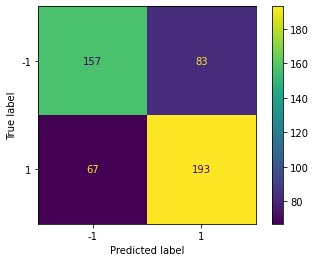

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.62      0.56      0.59       255
           1       0.59      0.64      0.61       245

    accuracy                           0.60       500
   macro avg       0.60      0.60      0.60       500
weighted avg       0.60      0.60      0.60       500

Confusion matrix
TP:		157
FP:		111
TN:		144
FN:		88


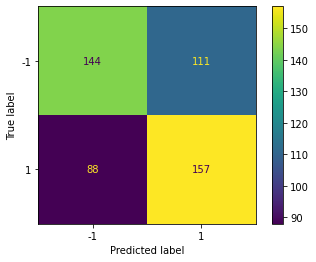

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.70      0.64      0.67       244
           1       0.68      0.74      0.71       256

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500

Confusion matrix
TP:		189
FP:		88
TN:		156
FN:		67


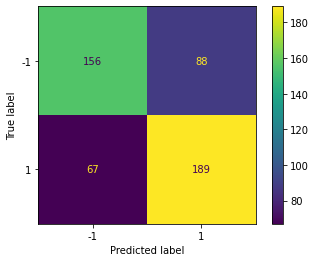

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.60      0.63      0.62       252
           1       0.61      0.57      0.59       248

    accuracy                           0.60       500
   macro avg       0.60      0.60      0.60       500
weighted avg       0.60      0.60      0.60       500

Confusion matrix
TP:		141
FP:		92
TN:		160
FN:		107


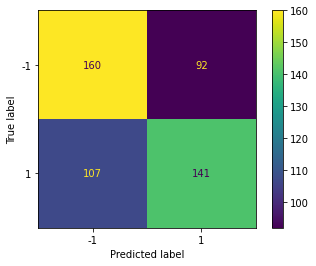

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.71      0.69      0.70       262
           1       0.67      0.68      0.67       238

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.69       500
weighted avg       0.69      0.69      0.69       500

Confusion matrix
TP:		163
FP:		82
TN:		180
FN:		75


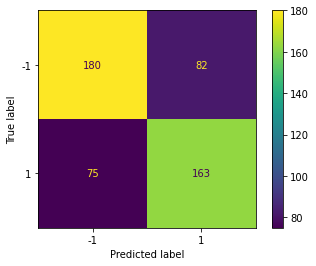

In [361]:
print('Train and test Word2Vec vectors:\n')

trainAndTestAll(positive_reviews_w2v, negative_reviews_w2v)

Train and test retrofitted Word2Vec vectors:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.71      0.60      0.65       266
           1       0.61      0.73      0.67       234

    accuracy                           0.66       500
   macro avg       0.66      0.66      0.66       500
weighted avg       0.67      0.66      0.66       500

Confusion matrix
TP:		170
FP:		107
TN:		159
FN:		64


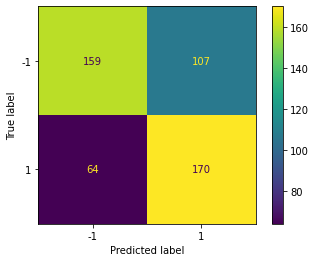

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.61      0.53      0.56       249
           1       0.59      0.67      0.62       251

    accuracy                           0.60       500
   macro avg       0.60      0.60      0.59       500
weighted avg       0.60      0.60      0.59       500

Confusion matrix
TP:		167
FP:		118
TN:		131
FN:		84


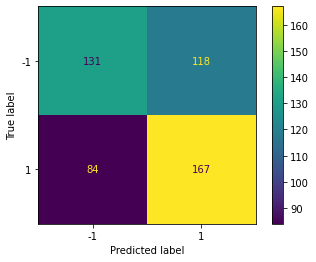

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       261
           1       0.48      1.00      0.64       239

    accuracy                           0.48       500
   macro avg       0.24      0.50      0.32       500
weighted avg       0.23      0.48      0.31       500

Confusion matrix
TP:		238
FP:		261
TN:		0
FN:		1


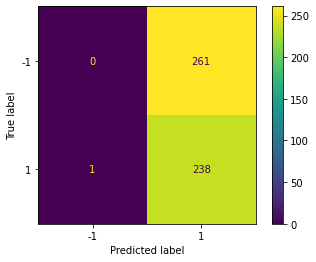

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.67      0.62      0.64       261
           1       0.62      0.67      0.64       239

    accuracy                           0.64       500
   macro avg       0.64      0.64      0.64       500
weighted avg       0.64      0.64      0.64       500

Confusion matrix
TP:		160
FP:		100
TN:		161
FN:		79


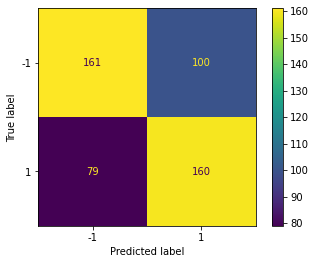

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.59      0.88      0.70       248
           1       0.77      0.40      0.53       252

    accuracy                           0.64       500
   macro avg       0.68      0.64      0.62       500
weighted avg       0.68      0.64      0.61       500

Confusion matrix
TP:		101
FP:		31
TN:		217
FN:		151


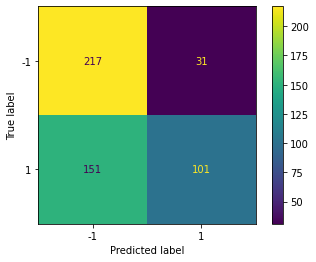

In [362]:
print('Train and test retrofitted Word2Vec vectors:\n')

trainAndTestAll(positive_reviews_w2vr, negative_reviews_w2vr)

Train and test Glove vectors:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.71      0.64      0.67       261
           1       0.64      0.72      0.68       239

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.68      0.68      0.68       500

Confusion matrix
TP:		172
FP:		95
TN:		166
FN:		67


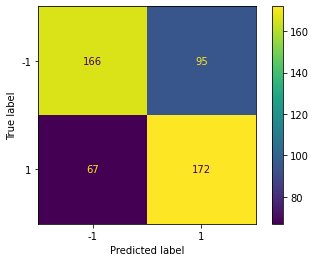

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.61      0.58      0.59       266
           1       0.55      0.58      0.56       234

    accuracy                           0.58       500
   macro avg       0.58      0.58      0.58       500
weighted avg       0.58      0.58      0.58       500

Confusion matrix
TP:		136
FP:		113
TN:		153
FN:		98


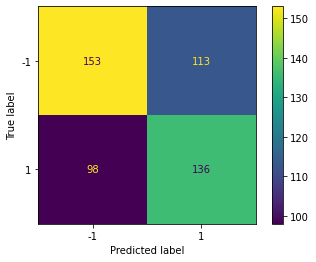

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.62      0.62      0.62       245
           1       0.63      0.63      0.63       255

    accuracy                           0.62       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.62      0.62      0.62       500

Confusion matrix
TP:		161
FP:		94
TN:		151
FN:		94


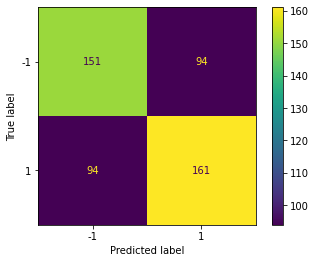

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.62      0.63      0.62       253
           1       0.61      0.60      0.61       247

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500

Confusion matrix
TP:		148
FP:		94
TN:		159
FN:		99


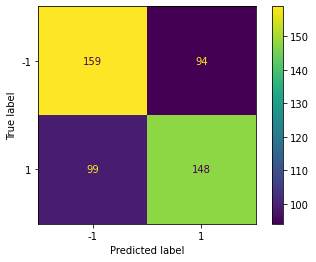

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.63      0.79      0.70       248
           1       0.72      0.54      0.62       252

    accuracy                           0.66       500
   macro avg       0.67      0.66      0.66       500
weighted avg       0.67      0.66      0.66       500

Confusion matrix
TP:		136
FP:		53
TN:		195
FN:		116


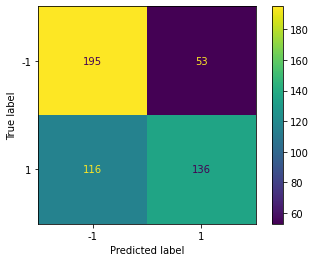

In [363]:
print('Train and test Glove vectors:\n')

trainAndTestAll(positive_reviews_glove, negative_reviews_glove)

Train and test retrofitted Glove vectors:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.71      0.62      0.67       261
           1       0.64      0.73      0.68       239

    accuracy                           0.67       500
   macro avg       0.68      0.68      0.67       500
weighted avg       0.68      0.67      0.67       500

Confusion matrix
TP:		174
FP:		98
TN:		163
FN:		65


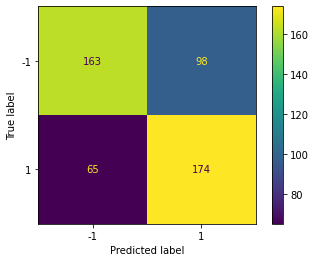

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.56      0.58      0.57       253
           1       0.55      0.53      0.54       247

    accuracy                           0.56       500
   macro avg       0.56      0.56      0.56       500
weighted avg       0.56      0.56      0.56       500

Confusion matrix
TP:		130
FP:		105
TN:		148
FN:		117


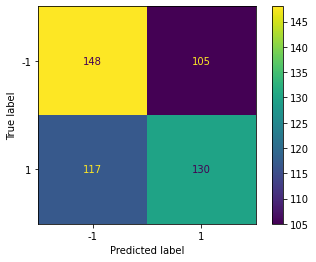

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.68      0.64      0.66       247
           1       0.67      0.70      0.69       253

    accuracy                           0.67       500
   macro avg       0.67      0.67      0.67       500
weighted avg       0.67      0.67      0.67       500

Confusion matrix
TP:		178
FP:		88
TN:		159
FN:		75


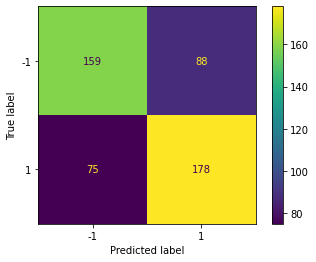

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.54      0.73      0.62       226
           1       0.69      0.49      0.57       274

    accuracy                           0.60       500
   macro avg       0.62      0.61      0.60       500
weighted avg       0.62      0.60      0.60       500

Confusion matrix
TP:		135
FP:		61
TN:		165
FN:		139


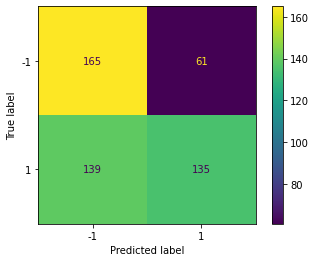

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.56      0.80      0.66       225
           1       0.75      0.49      0.60       275

    accuracy                           0.63       500
   macro avg       0.66      0.65      0.63       500
weighted avg       0.66      0.63      0.62       500

Confusion matrix
TP:		136
FP:		46
TN:		179
FN:		139


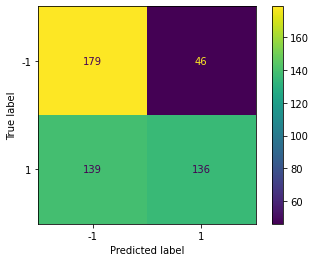

In [364]:
print('Train and test retrofitted Glove vectors:\n')

trainAndTestAll(positive_reviews_glover, negative_reviews_glover)

Train and test FastText vectors:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.64      0.74      0.69       237
           1       0.73      0.62      0.67       263

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.69      0.68      0.68       500

Confusion matrix
TP:		163
FP:		61
TN:		176
FN:		100


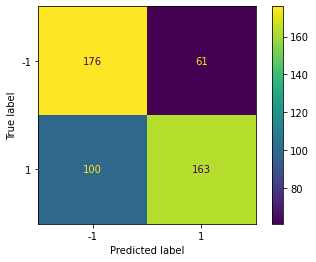

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.59      0.62      0.61       243
           1       0.62      0.60      0.61       257

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500

Confusion matrix
TP:		153
FP:		92
TN:		151
FN:		104


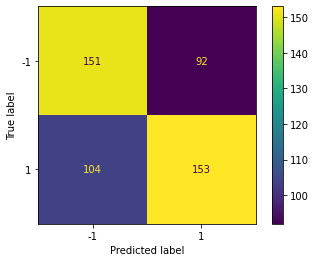

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.61      0.59      0.60       246
           1       0.62      0.64      0.63       254

    accuracy                           0.61       500
   macro avg       0.61      0.61      0.61       500
weighted avg       0.61      0.61      0.61       500

Confusion matrix
TP:		163
FP:		102
TN:		144
FN:		91


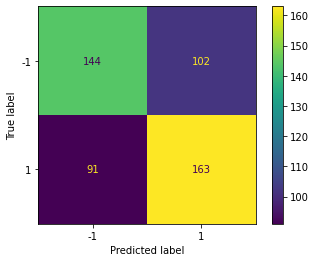

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.67      0.62      0.65       262
           1       0.62      0.67      0.64       238

    accuracy                           0.64       500
   macro avg       0.64      0.65      0.64       500
weighted avg       0.65      0.64      0.64       500

Confusion matrix
TP:		159
FP:		99
TN:		163
FN:		79


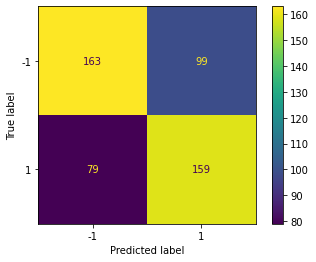

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.67      0.75      0.70       250
           1       0.71      0.62      0.67       250

    accuracy                           0.69       500
   macro avg       0.69      0.69      0.68       500
weighted avg       0.69      0.69      0.68       500

Confusion matrix
TP:		156
FP:		63
TN:		187
FN:		94


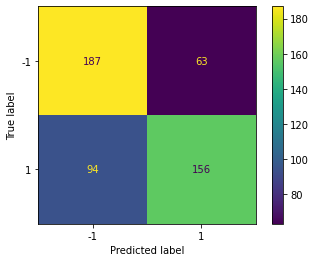

In [365]:
print('Train and test FastText vectors:\n')

trainAndTestAll(positive_reviews_ft, negative_reviews_ft)

Train and test Lesk disambiguation + DeConf sense embeddings:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.73      0.74      0.73       239
           1       0.76      0.75      0.75       261

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500

Confusion matrix
TP:		195
FP:		63
TN:		176
FN:		66


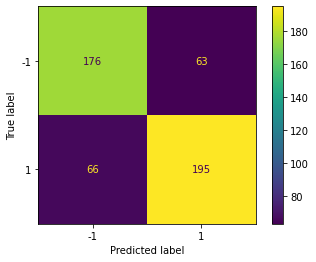

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.57      0.66      0.61       229
           1       0.67      0.58      0.62       271

    accuracy                           0.62       500
   macro avg       0.62      0.62      0.62       500
weighted avg       0.62      0.62      0.62       500

Confusion matrix
TP:		158
FP:		79
TN:		150
FN:		113


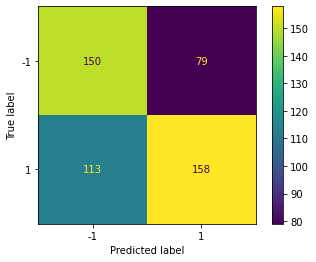

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.77      0.77      0.77       261
           1       0.75      0.74      0.75       239

    accuracy                           0.76       500
   macro avg       0.76      0.76      0.76       500
weighted avg       0.76      0.76      0.76       500

Confusion matrix
TP:		177
FP:		59
TN:		202
FN:		62


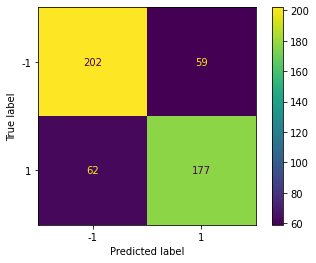

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.67      0.74      0.71       247
           1       0.72      0.65      0.68       253

    accuracy                           0.69       500
   macro avg       0.70      0.69      0.69       500
weighted avg       0.70      0.69      0.69       500

Confusion matrix
TP:		164
FP:		64
TN:		183
FN:		89


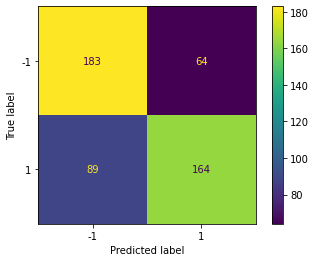

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.72      0.86      0.78       247
           1       0.83      0.67      0.74       253

    accuracy                           0.76       500
   macro avg       0.77      0.77      0.76       500
weighted avg       0.78      0.76      0.76       500

Confusion matrix
TP:		169
FP:		34
TN:		213
FN:		84


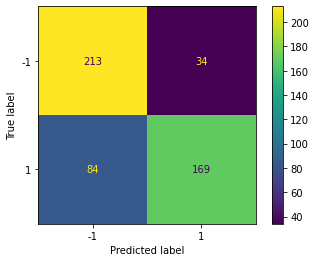

In [368]:
print('Train and test Lesk disambiguation + DeConf sense embeddings:\n')

trainAndTestAll(positive_reviews_lesk, negative_reviews_lesk)

Train and test Ewiser disambiguation + DeConf sense embeddings:

Multi-Layer Perceptron


              precision    recall  f1-score   support

          -1       0.81      0.81      0.81       243
           1       0.82      0.82      0.82       257

    accuracy                           0.82       500
   macro avg       0.82      0.82      0.82       500
weighted avg       0.82      0.82      0.82       500

Confusion matrix
TP:		212
FP:		45
TN:		198
FN:		45


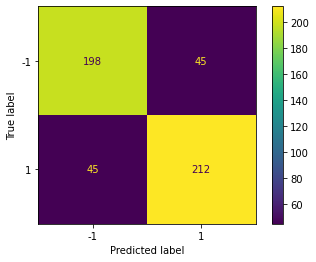

-------------------------------------------------------

K-Nearest Neighbours


              precision    recall  f1-score   support

          -1       0.70      0.69      0.70       244
           1       0.71      0.72      0.72       256

    accuracy                           0.71       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.71      0.71      0.71       500

Confusion matrix
TP:		185
FP:		75
TN:		169
FN:		71


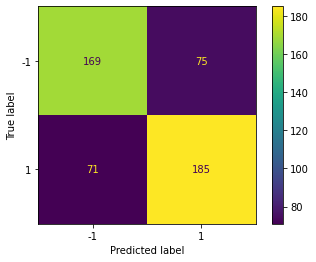

-------------------------------------------------------

Support Vector Machine


              precision    recall  f1-score   support

          -1       0.79      0.79      0.79       257
           1       0.77      0.78      0.78       243

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500

Confusion matrix
TP:		189
FP:		55
TN:		202
FN:		54


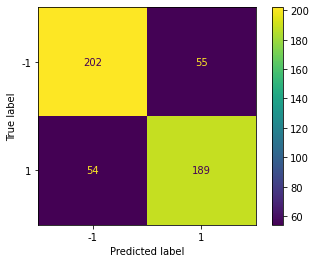

-------------------------------------------------------

Random Forest


              precision    recall  f1-score   support

          -1       0.77      0.77      0.77       243
           1       0.78      0.79      0.78       257

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500

Confusion matrix
TP:		202
FP:		56
TN:		187
FN:		55


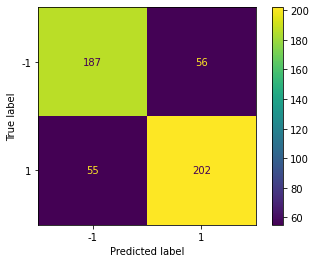

-------------------------------------------------------

Ensemble


              precision    recall  f1-score   support

          -1       0.76      0.86      0.81       244
           1       0.85      0.74      0.79       256

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500

Confusion matrix
TP:		190
FP:		33
TN:		211
FN:		66


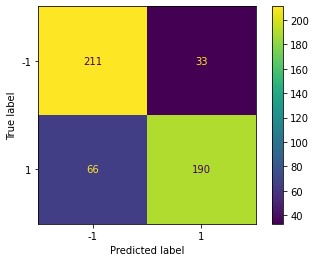

In [372]:
print('Train and test Ewiser disambiguation + DeConf sense embeddings:\n')

trainAndTestAll(positive_reviews_ewiser, negative_reviews_ewiser)